In [ ]:
# Plots of received data in 1M PHY: Phase and Phase difference 

import math
import cmath
import json
import numpy as np
import matplotlib.pyplot as plt

### Methods
def to_plus_minus_pi(angle):
    while angle >= 180:
        angle -= 2 * 180
    while angle < -180:
        angle += 2 * 180
    return angle

data = {
    "IQ":[[2,-12],[11,2],[-4,10],
        [-11,-5],[5,-10],[9,6],
        [-8,9],[-9,-7],[7,8],
        [-8,-10],[5,10],[-4,-12],
        [2,11],[-2,-12],[-2,11],
        [3,-11],[-5,10],[5,-10],
        [-7,9],[8,-9],[-9,7],
        [10,-6],[-11,4],[11,-4],
        [-12,1],[11,1],[-12,-2],
        [10,3],[-11,-5],[9,6],
        [-10,-7],[7,8],[-6,-10],
        [5,9],[-4,-11],[1,11],
        [-1,-12],[-1,11],[3,-12],
        [-5,10],[5,-11],[-7,9],
        [7,-9],[-9,6],[9,-6],
        [-11,3],[10,-3],[-12,0],
        [11,1],[-12,-2],[10,3],
        [-11,-6],[9,5],[-9,-8],
        [7,8],[-7,-10],[4,10],
        [-5,-11],[1,11],[0,-12],
        [-2,11],[2,-12],[-4,11],
        [6,-10],[-8,8],[8,-9],
        [-9,7],[9,-6],[-11,4],
        [11,-3],[-12,1],[11,-1],
        [-12,-3],[10,2],[-10,-6],
        [10,5],[-8,-8],[7,9],
        [-6,-11],[5,10],[-3,-12],
        [1,11]]}

    Phases = []
    PhasesDiff = []
    for i in range(len(data['IQ'])-1):
        iq_next = complex(data['IQ'][i + 1][0], data['IQ'][i + 1][1])
        iq_current = complex(data['IQ'][i][0], data['IQ'][i][1])
        phase_next = np.rad2deg(np.arctan2(iq_next.imag, iq_next.real))
        phase_current = np.rad2deg(np.arctan2(iq_current.imag, iq_current.real))
        Phases.append(phase_current)
        PhasesDiff.append((to_plus_minus_pi(phase_next - phase_current)))

    print(Phases)
    plt.figure(figsize=(16, 10), dpi=100)
    plt.plot(Phases)
    plt.show()

    print(PhasesDiff)
    plt.figure(figsize=(16, 10), dpi=100)
    plt.plot(PhasesDiff)
    plt.show()

In [ ]:
import pathlib

pathlib.Path("logs").mkdir(exist_ok=True)
print(pathlib.Path().absolute())


In [ ]:
# Plots of received data in 1M PHY: Phase and Phase difference (SIMPLE HORIZONTAL/VERTICAL PATTERN)

import math
import cmath
import json
import numpy as np
import matplotlib.pyplot as plt

###################################################################
### Constants

vel_air = 299702547 # m/s
d = 0.05

###################################################################
### Methods

def to_plus_minus_pi(angle):
    while angle >= 180:
        angle -= 2 * 180
    while angle < -180:
        angle += 2 * 180
    return angle

def calc_mean(values):
    return sum(values)/len(values)

def calc_angle(deg_value, inverted, results, freq):
    wave_len = vel_air/freq
    output = 0
    try:
        result = math.acos((np.deg2rad(deg_value)*wave_len)/(2*math.pi*d))
    except ValueError:
        pass
    else:
        if inverted:
            output = abs(to_plus_minus_pi(np.rad2deg(result)+180))
        else:
            output = abs(to_plus_minus_pi(np.rad2deg(result)))
        results.append(output)

def channel_2_freq(channel):
    freq = 2450 #MHz
    if(channel <= 10):
        freq = 2404 + channel*2
    elif(channel < 37):
        freq = 2428 + (channel-11)*2
    elif(channel == 37):
        freq = 2402
    elif(channel == 38):
        freq = 2426
    else:
        freq = 2480
    return freq*1000000

###################################################################

data = []

# Load data with only valid IQ samples from JSON log  

# with open('../logs/outdoor/2022.10.23/log_2022.10.23_13.49.34.json') as f: # 0 deg TRASH
with open('../logs/outdoor/2022.10.23/log_2022.10.23_13.52.22.json') as f: # 30 deg OK
# with open('../logs/outdoor/2022.10.23/log_2022.10.23_13.54.57.json') as f: # 45 deg
# with open('../logs/outdoor/2022.10.23/log_2022.10.23_13.57.36.json') as f: # 60 deg
# with open('../logs/outdoor/2022.10.23/log_2022.10.23_13.59.39.json') as f: # 90 deg
# with open('../logs/outdoor/2022.10.23/log_2022.10.23_14.01.51.json') as f: # 120 deg
# with open('../logs/outdoor/2022.10.23/log_2022.10.23_14.09.12.json') as f: # 135 deg
# with open('../logs/outdoor/2022.10.23/log_2022.10.23_14.26.24.json') as f: # 150 deg
# with open('../logs/indoor/2022.11.04/log_2022.11.04_22.24.54.json') as f:  #90 deg indoor
# with open('../logs/indoor/2022.11.04/log_2022.11.04_22.39.17.json') as f:  #110 deg indoor
# with open('../logs/indoor/2022.11.04/log_2022.11.04_22.43.31.json') as f:  #140 deg indoor
    log = json.load(f)
    record_data = {
        "Header": log["Header"],
        "Records": [elem for elem in log["Records"] if len(elem["IQ"]) > 80]
    }
    data.append(record_data)

results = []

# Iterate through each connection event 
for n in range(len(data[0]["Records"])-1):
    channel = data[0]["Records"][n]["Channel"]
    
    IQ = []
    result = []

    # Iterate through each IQ sample to normalize it 
    for elem in data[0]["Records"][n]["IQ"]:
        I = elem[0]/128 if elem[0] < 0 else elem[0]/127
        Q = elem[1]/128 if elem[1] < 0 else elem[1]/127
        IQ.append(complex(I,Q))

    refPeriodDiff = []
    sampPeriodDiff = []
    refMeanDiff = 0

    # Iterate through each sample (82) in one connection event 
    for i in range(len(IQ)-1):
        # Phase calculation from IQ samples
        phaseCurrent = np.rad2deg(np.arctan2(IQ[i].imag, IQ[i].real))
        phaseNext = np.rad2deg(np.arctan2(IQ[i + 1].imag, IQ[i + 1].real))

        if (i < 7):
            refPeriodDiff.append(abs(to_plus_minus_pi(phaseNext - phaseCurrent)))
        elif (i == 7):
            refMeanDiff = calc_mean(refPeriodDiff)
        else:
            sampPeriodDiff.append(to_plus_minus_pi((phaseNext - phaseCurrent) - 2*refMeanDiff))

    # Calculate azimuth angles
    inverted = False
    for i in range(len(sampPeriodDiff)-1):
        # Skip difference between last and first measurement in upper and lower section
        if ((i + 1) % 4 == 0):
            # Invert in lower section due to opposite scanning direction
            inverted = not inverted
        else:
            calc_angle(sampPeriodDiff[i], inverted, result, channel_2_freq(channel))

    results.append(calc_mean(result))

    print(f"# {n} Channel: {channel} Freq: {channel_2_freq(channel)}")
    print(f"(11-12) Diff: {sampPeriodDiff[0]} Angle: {result[0]}")
    print(f"(12-01) Diff: {sampPeriodDiff[1]} Angle: {result[1]}")
    print(f"(01-02) Diff: {sampPeriodDiff[2]} Angle: {result[2]}")

    print(f"(05-06) Diff: {sampPeriodDiff[3]} Angle: {result[3]}")
    print(f"(06-07) Diff: {sampPeriodDiff[4]} Angle: {result[4]}")
    print(f"(07-08) Diff: {sampPeriodDiff[5]} Angle: {result[5]}")

    print(f"(11-12) Diff: {sampPeriodDiff[6]} Angle: {result[6]}")
    print(f"(12-01) Diff: {sampPeriodDiff[7]} Angle: {result[7]}")
    print(f"(01-02) Diff: {sampPeriodDiff[8]} Angle: {result[8]}")

    print(f"(05-06) Diff: {sampPeriodDiff[9]} Angle: {result[9]}")
    print(f"(06-07) Diff: {sampPeriodDiff[10]} Angle: {result[10]}")
    print(f"(07-08) Diff: {sampPeriodDiff[11]} Angle: {result[11]}")

# print(results)
# print(calc_mean(results))

# Plot phases
# plt.figure(figsize=(16, 10), dpi=100)
# plt.plot(Phases)
# plt.show()

# Plot reference difference of phases
# plt.figure(figsize=(16, 10), dpi=100)
# plt.plot(refPeriodDiff)
# plt.show()

# Plot sampling difference of phases
# plt.figure(figsize=(16, 10), dpi=100)
# plt.plot(sampPeriodDiff)
# plt.show()

# TODO It looks like eliminating 6th sample from each measurement would improve accuracy as difference between 8 and 7th antenna is invalid


In [ ]:
# Plots of received data in 1M and 2M PHY: Phase and Phase difference (COMPLEX PATTERN)
import math
import cmath
import json
import numpy as np
import matplotlib.pyplot as plt

###################################################################
### Constants

vel_air = 299702547 # m/s
d = 0.05

###################################################################
### Methods

def to_plus_minus_pi(angle):
    while angle >= 180:
        angle -= 2 * 180
    while angle < -180:
        angle += 2 * 180
    return angle

def calc_mean(values):
    return sum(values)/len(values)

def calc_angle(deg_value, inverted, results, freq):
    wave_len = vel_air/freq
    output = 0
    try:
        result = math.acos((np.deg2rad(deg_value)*wave_len)/(2*math.pi*d))
    except ValueError:
        pass
    else:
        if inverted:
            output = abs(to_plus_minus_pi(np.rad2deg(result)+180))
        else:
            output = abs(to_plus_minus_pi(np.rad2deg(result)))
        results.append(output)

def channel_2_freq(channel):
    freq = 2450 #MHz
    if(channel <= 10):
        freq = 2404 + channel*2
    elif(channel < 37):
        freq = 2428 + (channel-11)*2
    elif(channel == 37):
        freq = 2402
    elif(channel == 38):
        freq = 2426
    else:
        freq = 2480
    return freq*1000000

###################################################################

data = []

# Load data with only valid IQ samples from JSON log  
# with open('../logs/outdoor/2022.10.31/log_2022.10.31_15.48.07.json') as f:  # 60deg max height
# with open('../logs/outdoor/2022.10.31/log_2022.10.31_15.33.48.json') as f:  # 60deg mid height
# with open('../logs/outdoor/2022.10.31/log_2022.10.31_15.07.55.json') as f:  # 60deg min height
# with open('../logs/outdoor/2022.10.31/log_2022.10.31_15.50.06.json') as f:  # 90deg max height
# with open('../logs/outdoor/2022.10.31/log_2022.10.31_15.32.02.json') as f:  # 90deg mid height
# with open('../logs/outdoor/2022.10.31/log_2022.10.31_15.09.56.json') as f:  # 90deg min height
with open('../logs/outdoor/2022.10.31/log_2022.10.31_16.51.51.json') as f:  # 45deg min height 2M PHY
        
    log = json.load(f)
    record_data = {
        "Header": log["Header"],
        "Records": [elem for elem in log["Records"] if len(elem["IQ"]) > 80]
    }
    data.append(record_data)

results_azimuth = []
results_elevation = []

# Iterate through each connection event 
for n in range(len(data[0]["Records"])-1):
    channel = data[0]["Records"][n]["Channel"]
    IQ = []

    # Iterate through each IQ sample to normalize it 
    for elem in data[0]["Records"][n]["IQ"]:
        I = elem[0]/128 if elem[0] < 0 else elem[0]/127
        Q = elem[1]/128 if elem[1] < 0 else elem[1]/127
        IQ.append(complex(I,Q))

    refPeriodDiff = []
    sampPeriodDiff = []
    refMeanDiff = 0

    # Iterate through each sample (82) in one connection event 
    for i in range(len(IQ)-1):
        
        # Phase calculation from IQ samples
        phaseCurrent = np.rad2deg(np.arctan2(IQ[i].imag, IQ[i].real))
        phaseNext = np.rad2deg(np.arctan2(IQ[i + 1].imag, IQ[i + 1].real))

        if (i < 7):
            refPeriodDiff.append(abs(to_plus_minus_pi(phaseNext - phaseCurrent)))
        elif (i == 7):
            refMeanDiff = calc_mean(refPeriodDiff)
        else:
            sampPeriodDiff.append(to_plus_minus_pi((phaseNext - phaseCurrent) - 2*refMeanDiff))

    azimuth = []
    elevation = []
    inverted = False
    horizontal = True

    # Calculate direction angles
    for i in range(len(sampPeriodDiff)-1):
        # Skip corner differences samples
        if ((i + 1) % 4 == 0):
            if(not horizontal): 
                # Change to inverted after 2 sections of non inverted data due to opposite scanning direction
                inverted = not inverted
            # Change orientation after each section 
            horizontal = not horizontal
        else:
            if (horizontal):
                calc_angle(sampPeriodDiff[i], inverted, azimuth, channel_2_freq(channel))
            else:
                calc_angle(sampPeriodDiff[i], inverted, elevation, channel_2_freq(channel))

    results_azimuth.append(calc_mean(azimuth))
    results_elevation.append(calc_mean(elevation))

print(f"Azimuth mean: {calc_mean(results_azimuth)}")
print(f"Elevation mean: {calc_mean(results_elevation)}")

In [ ]:
# Plots of received data in 1M and 2M PHY: Phase and Phase difference (COMPLEX PATTERN)

import math
import cmath
import json
from mpl_toolkits.axisartist.axislines import AxesZero
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

###################################################################
### Constants

vel_air = 299702547 # m/s
d = 0.05

###################################################################
### Methods

def to_plus_minus_pi(angle):
    while angle >= 180:
        angle -= 2 * 180
    while angle < -180:
        angle += 2 * 180
    return angle

def calc_mean(values):
    return sum(values)/len(values)

def calc_angle(deg_value, inverted, results, freq):
    wave_len = vel_air/freq
    output = 0
    try:
        result = math.acos((np.deg2rad(deg_value)*wave_len)/(2*math.pi*d))
    except ValueError:
        pass
    else:
        if inverted:
            output = abs(to_plus_minus_pi(np.rad2deg(result)+180))
        else:
            output = abs(to_plus_minus_pi(np.rad2deg(result)))
        results.append(output)

def channel_2_freq(channel):
    freq = 2450 #MHz
    if(channel <= 10):
        freq = 2404 + channel*2
    elif(channel < 37):
        freq = 2428 + (channel-11)*2
    elif(channel == 37):
        freq = 2402
    elif(channel == 38):
        freq = 2426
    else:
        freq = 2480
    return freq*1000000

###################################################################

data = []

# Load data with only valid IQ samples from JSON log  
# with open('../logs/outdoor/2022.10.31/log_2022.10.31_16.51.51.json') as f:  # 45deg min height 2M PHY
with open('../logs/outdoor/2022.10.31/log_2022.10.31_15.05.16.json') as f:  # 45deg min height 1M PHY
# with open('../logs/outdoor/2022.10.31/log_2022.10.31_15.03.12.json') as f:  # 30deg min height 1M PHY
    
        
    log = json.load(f)
    record_data = {
        "Header": log["Header"],
        "Records": [elem for elem in log["Records"] if len(elem["IQ"]) > 80]
    }
    data.append(record_data)

results_azimuth = []
results_elevation = []

# Iterate through each connection event 
for n in range(len(data[0]["Records"])-1):
    IQ = []
    channel = data[0]["Records"][n]["Channel"]

    # Iterate through each IQ sample to normalize it 
    for elem in data[0]["Records"][n]["IQ"]:
        I = elem[0]/128 if elem[0] < 0 else elem[0]/127
        Q = elem[1]/128 if elem[1] < 0 else elem[1]/127
        IQ.append(complex(I,Q))

    refPeriodDiff = []
    sampPeriodDiff = []
    refMeanDiff = 0

    # Iterate through each sample (82) in one connection event 
    for i in range(len(IQ)-1):
        # Phase calculation from IQ samples
        phaseCurrent = np.rad2deg(np.arctan2(IQ[i].imag, IQ[i].real))
        phaseNext = np.rad2deg(np.arctan2(IQ[i + 1].imag, IQ[i + 1].real))

        if (i < 7):
            refPeriodDiff.append(abs(to_plus_minus_pi(phaseNext - phaseCurrent)))
        elif (i == 7):
            refMeanDiff = calc_mean(refPeriodDiff)
        else:
            # 2*refMeanDiff as a in ref period sample is taken twice as fast as in sampling period, 
            # so it needs to be doubled
            sampPeriodDiff.append(to_plus_minus_pi((phaseNext - phaseCurrent) - 2*refMeanDiff))

    azimuth = []
    elevation = []
    inverted = False
    horizontal = True

    # Calculate direction angles
    for i in range(len(sampPeriodDiff)-1):
        # Skip corner differences samples
        if ((i + 1) % 4 == 0):
            if(not horizontal): 
                # Change to inverted after 2 sections of non inverted data due to opposite scanning direction
                inverted = not inverted
            # Change orientation after each section 
            horizontal = not horizontal
        else:
            if (horizontal):
                calc_angle(sampPeriodDiff[i], inverted, azimuth, channel_2_freq(channel))
            else:
                calc_angle(sampPeriodDiff[i], inverted, elevation, channel_2_freq(channel))

    results_azimuth.append(calc_mean(azimuth))
    results_elevation.append(calc_mean(elevation))

x = [30, 45, 60, 90, 135, 150]
y = [30, 45, 60, 90, 135, 150]

def animate(i):
    # out.set_xdata(results_azimuth[i]-90)
    # out.set_ydata(results_elevation[i]-90)
    out.set_xdata(x[i]-90)
    out.set_ydata(y[i]-90)
    return out,

fig = plt.figure(figsize=(16, 10), dpi=100)
ax = fig.add_subplot(axes_class=AxesZero)
out, = ax.plot(results_azimuth[i]-90, results_elevation[i]-90,'ro')

for direction in ["xzero", "yzero"]:
    # adds X and Y-axis from the origin
    ax.axis[direction].set_visible(True)

for direction in ["left", "right", "bottom", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)
    
ax.grid(True)
ax.set_title("Direction radar")
ax.set_xlim(-90,90)
ax.set_ylim(-90,90)
ticks = np.arange(-90,91,30)
ax.xaxis.set_ticks(ticks, [f"${i}\degree$" for i in ticks])
ax.yaxis.set_ticks(ticks, [f"${i}\degree$" for i in ticks])

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# %matplotlib notebook

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i / 50))  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, interval=20, blit=True, save_count=50)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

Azimuth min: -1.2807828707721427, max: 1.102594560755719
Elevation min: -1.0297783074928475, max: 1.3045656142327715
0.07698512508014123
0.08943040889060394
0.09109160306251608
0.07189983021475886
Samples count: 173


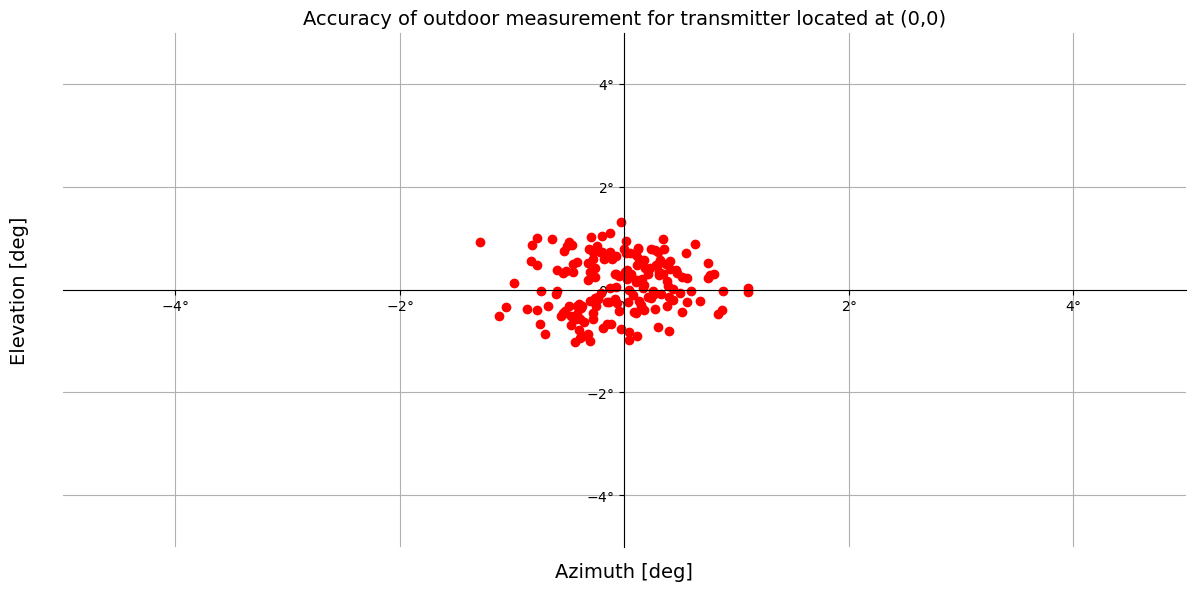

In [25]:
# Plots of received data in 1M and 2M PHY: Phase and Phase difference (COMPLEX PATTERN)

import math
import cmath
import json
from mpl_toolkits.axisartist.axislines import AxesZero
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

###################################################################
### Constants

vel_air = 299702547 # m/s
d = 0.05

###################################################################
### Methods

def to_plus_minus_pi(angle):
    while angle >= 180:
        angle -= 2 * 180
    while angle < -180:
        angle += 2 * 180
    return angle

def calc_mean(values):
    return sum(values)/len(values)

def calc_angle(deg_value, inverted, results, freq):
    wave_len = vel_air/freq
    output = 0
    try:
        result = math.acos((np.deg2rad(deg_value)*wave_len)/(2*math.pi*d))
    except ValueError:
        pass
    else:
        if inverted:
            output = abs(to_plus_minus_pi(np.rad2deg(result)+180))
        else:
            output = abs(to_plus_minus_pi(np.rad2deg(result)))
        results.append(output)

def channel_2_freq(channel):
    freq = 2450 #MHz
    if(channel <= 10):
        freq = 2404 + channel*2
    elif(channel < 37):
        freq = 2428 + (channel-11)*2
    elif(channel == 37):
        freq = 2402
    elif(channel == 38):
        freq = 2426
    else:
        freq = 2480
    return freq*1000000

###################################################################

data = []

with open('../logs/outdoor/2022.11.15/log_2022.11.15_10.58.00.json') as f:
    log = json.load(f)
    record_data = {
        "Header": log["Header"],
        "Records": [elem for elem in log["Records"] if len(elem["IQ"]) > 80]
    }
    data.append(record_data)

results_azimuth = []
results_elevation = []

# Iterate through each connection event 
for n in range(len(data[0]["Records"])-1):
    IQ = []
    channel = data[0]["Records"][n]["Channel"]

    # Iterate through each IQ sample to normalize it 
    for elem in data[0]["Records"][n]["IQ"]:
        I = elem[0]/128 if elem[0] < 0 else elem[0]/127
        Q = elem[1]/128 if elem[1] < 0 else elem[1]/127
        IQ.append(complex(I,Q))

    refPeriodDiff = []
    sampPeriodDiff = []
    refMeanDiff = 0

    # Iterate through each sample (82) in one connection event 
    for i in range(len(IQ)-1):
        # Phase calculation from IQ samples
        phaseCurrent = np.rad2deg(np.arctan2(IQ[i].imag, IQ[i].real))
        phaseNext = np.rad2deg(np.arctan2(IQ[i + 1].imag, IQ[i + 1].real))

        if (i < 7):
            refPeriodDiff.append(abs(to_plus_minus_pi(phaseNext - phaseCurrent)))
        elif (i == 7):
            refMeanDiff = calc_mean(refPeriodDiff)
        else:
            # 2*refMeanDiff as a in ref period sample is taken twice as fast as in sampling period, 
            # so it needs to be doubled
            sampPeriodDiff.append(to_plus_minus_pi((phaseNext - phaseCurrent) - 2*refMeanDiff))

    azimuth = []
    elevation = []
    inverted = False
    horizontal = True

    # Calculate direction angles
    for i in range(len(sampPeriodDiff)-1):
        # Skip corner differences samples
        if ((i + 1) % 4 == 0):
            if(not horizontal): 
                # Change to inverted after 2 sections of non inverted data due to opposite scanning direction
                inverted = not inverted
            # Change orientation after each section 
            horizontal = not horizontal
        else:
            if (horizontal):
                calc_angle(sampPeriodDiff[i], inverted, azimuth, channel_2_freq(channel))
            else:
                calc_angle(sampPeriodDiff[i], inverted, elevation, channel_2_freq(channel))

    results_azimuth.append(calc_mean(azimuth)-90)
    results_elevation.append(calc_mean(elevation)-90)

print(f"Azimuth min: {min(results_azimuth)}, max: {max(results_azimuth)}")
print(f"Elevation min: {min(results_elevation)}, max: {max(results_elevation)}")

print(abs(math.tan(np.deg2rad(max(results_azimuth)))*4))
print(abs(math.tan(np.deg2rad(min(results_azimuth)))*4))
print(abs(math.tan(np.deg2rad(max(results_elevation)))*4))
print(abs(math.tan(np.deg2rad(min(results_elevation)))*4))

# print(abs(math.tan(np.deg2rad(min(results_azimuth)))*4) + abs(math.tan(np.deg2rad(max(results_azimuth)))*4))
# print(abs(math.tan(np.deg2rad(min(results_elevation)))*4) + abs(math.tan(np.deg2rad(max(results_elevation)))*4))

# print(f"Azimuth min: {min(results_azimuth)}, max: {max(results_azimuth)}")
# print(f"Elevation min: {min(results_elevation)}, max: {max(results_elevation)}")

print(f"Samples count: {len(results_azimuth)}")

fig = plt.figure(figsize=(12, 6), dpi=100)
ax = fig.add_subplot()
ax.plot(results_azimuth, results_elevation, 'ro')
ax.grid(True)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)  
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.xaxis.set_label_coords(0, -0.03)
ax.yaxis.set_label_coords(-0.03, 0)
ax.set_ylabel('Elevation [deg]', fontsize='14')
ax.set_xlabel('Azimuth [deg]', fontsize='14')
ticks = np.arange(-4,5,2)
ax.xaxis.set_ticks(ticks, [f"${i}\degree$" for i in ticks])
ax.yaxis.set_ticks(ticks, [f"${i}\degree$" for i in ticks])
ax.set_title("Accuracy of outdoor measurement for transmitter located at (0,0)", fontsize='14')
plt.tight_layout()
plt.show()

0.13275247599378603
0.2610827737786417
0.22562672346355125
0.1740393104629917
Azimuth min: -3.7344380417738847, max: 1.9008414587276832
Elevation min: -2.4913581483240392, max: 3.22844365582489
Samples count: 167


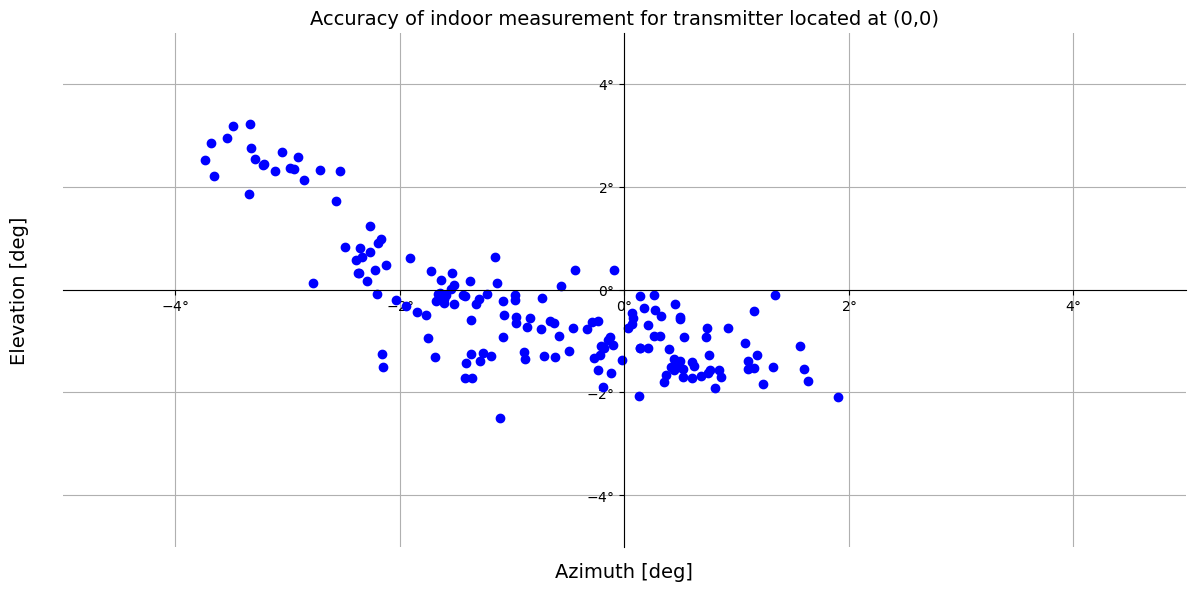

In [26]:
# Plots of received data in 1M and 2M PHY: Phase and Phase difference (COMPLEX PATTERN)

import math
import cmath
import json
from mpl_toolkits.axisartist.axislines import AxesZero
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

###################################################################
### Constants

vel_air = 299702547 # m/s
d = 0.05

###################################################################
### Methods

def to_plus_minus_pi(angle):
    while angle >= 180:
        angle -= 2 * 180
    while angle < -180:
        angle += 2 * 180
    return angle

def calc_mean(values):
    return sum(values)/len(values)

def calc_angle(deg_value, inverted, results, freq):
    wave_len = vel_air/freq
    output = 0
    try:
        result = math.acos((np.deg2rad(deg_value)*wave_len)/(2*math.pi*d))
    except ValueError:
        pass
    else:
        if inverted:
            output = abs(to_plus_minus_pi(np.rad2deg(result)+180))
        else:
            output = abs(to_plus_minus_pi(np.rad2deg(result)))
        results.append(output)

def channel_2_freq(channel):
    freq = 2450 #MHz
    if(channel <= 10):
        freq = 2404 + channel*2
    elif(channel < 37):
        freq = 2428 + (channel-11)*2
    elif(channel == 37):
        freq = 2402
    elif(channel == 38):
        freq = 2426
    else:
        freq = 2480
    return freq*1000000

###################################################################

data = []

with open('../logs/outdoor/2022.11.23/log_2022.11.23_00.08.01.json') as f:
    log = json.load(f)
    record_data = {
        "Header": log["Header"],
        "Records": [elem for elem in log["Records"] if len(elem["IQ"]) > 80]
    }
    data.append(record_data)

results_azimuth = []
results_elevation = []

# Iterate through each connection event 
for n in range(len(data[0]["Records"])-1):
    IQ = []
    channel = data[0]["Records"][n]["Channel"]

    # Iterate through each IQ sample to normalize it 
    for elem in data[0]["Records"][n]["IQ"]:
        I = elem[0]/128 if elem[0] < 0 else elem[0]/127
        Q = elem[1]/128 if elem[1] < 0 else elem[1]/127
        IQ.append(complex(I,Q))

    refPeriodDiff = []
    sampPeriodDiff = []
    refMeanDiff = 0

    # Iterate through each sample (82) in one connection event 
    for i in range(len(IQ)-1):
        # Phase calculation from IQ samples
        phaseCurrent = np.rad2deg(np.arctan2(IQ[i].imag, IQ[i].real))
        phaseNext = np.rad2deg(np.arctan2(IQ[i + 1].imag, IQ[i + 1].real))

        if (i < 7):
            refPeriodDiff.append(abs(to_plus_minus_pi(phaseNext - phaseCurrent)))
        elif (i == 7):
            refMeanDiff = calc_mean(refPeriodDiff)
        else:
            # 2*refMeanDiff as a in ref period sample is taken twice as fast as in sampling period, 
            # so it needs to be doubled
            sampPeriodDiff.append(to_plus_minus_pi((phaseNext - phaseCurrent) - 2*refMeanDiff))

    azimuth = []
    elevation = []
    inverted = False
    horizontal = True

    # Calculate direction angles
    for i in range(len(sampPeriodDiff)-1):
        # Skip corner differences samples
        if ((i + 1) % 4 == 0):
            if(not horizontal): 
                # Change to inverted after 2 sections of non inverted data due to opposite scanning direction
                inverted = not inverted
            # Change orientation after each section 
            horizontal = not horizontal
        else:
            if (horizontal):
                calc_angle(sampPeriodDiff[i], inverted, azimuth, channel_2_freq(channel))
            else:
                calc_angle(sampPeriodDiff[i], inverted, elevation, channel_2_freq(channel))

    results_azimuth.append(calc_mean(azimuth)-90)
    results_elevation.append(calc_mean(elevation)-90)

print(abs(math.tan(np.deg2rad(max(results_azimuth)))*4))
print(abs(math.tan(np.deg2rad(min(results_azimuth)))*4))
print(abs(math.tan(np.deg2rad(max(results_elevation)))*4))
print(abs(math.tan(np.deg2rad(min(results_elevation)))*4))

print(f"Azimuth min: {min(results_azimuth)}, max: {max(results_azimuth)}")
print(f"Elevation min: {min(results_elevation)}, max: {max(results_elevation)}")
print(f"Samples count: {len(results_azimuth)}")

fig = plt.figure(figsize=(12, 6), dpi=100)
ax = fig.add_subplot()
ax.plot(results_azimuth, results_elevation, 'bo')
ax.grid(True)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)  
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.xaxis.set_label_coords(0, -0.03)
ax.yaxis.set_label_coords(-0.03, 0)
ax.set_ylabel('Elevation [deg]', fontsize='14')
ax.set_xlabel('Azimuth [deg]', fontsize='14')
ticks = np.arange(-4,5,2)
ax.xaxis.set_ticks(ticks, [f"${i}\degree$" for i in ticks])
ax.yaxis.set_ticks(ticks, [f"${i}\degree$" for i in ticks])
ax.set_title("Accuracy of indoor measurement for transmitter located at (0,0)", fontsize='14')
plt.tight_layout()
plt.show()

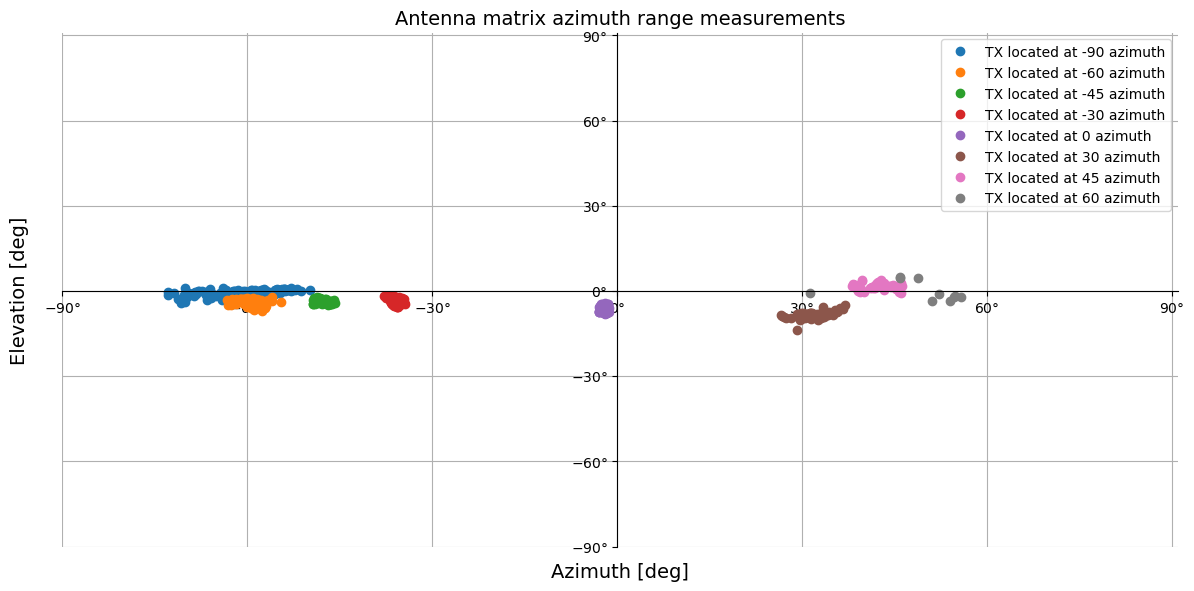

In [61]:
# Plots of received data in 1M and 2M PHY: Phase and Phase difference (COMPLEX PATTERN)

import math
import cmath
import json
from mpl_toolkits.axisartist.axislines import AxesZero
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

###################################################################
### Constants

vel_air = 299702547 # m/s
d = 0.05

###################################################################
### Methods

def to_plus_minus_pi(angle):
    while angle >= 180:
        angle -= 2 * 180
    while angle < -180:
        angle += 2 * 180
    return angle

def calc_mean(values):
    return sum(values)/len(values)

def calc_angle(deg_value, inverted, results, freq):
    wave_len = vel_air/freq
    output = 0
    try:
        result = math.acos((np.deg2rad(deg_value)*wave_len)/(2*math.pi*d))
    except ValueError:
        pass
    else:
        if inverted:
            output = abs(to_plus_minus_pi(np.rad2deg(result)+180))
        else:
            output = abs(to_plus_minus_pi(np.rad2deg(result)))
        results.append(output)

def channel_2_freq(channel):
    freq = 2450 #MHz
    if(channel <= 10):
        freq = 2404 + channel*2
    elif(channel < 37):
        freq = 2428 + (channel-11)*2
    elif(channel == 37):
        freq = 2402
    elif(channel == 38):
        freq = 2426
    else:
        freq = 2480
    return freq*1000000

###################################################################

max = ["log_2022.10.31_15.42.39.json", "log_2022.10.31_15.44.27.json", 
        "log_2022.10.31_15.46.15.json", "log_2022.10.31_15.48.07.json", 
        "log_2022.10.31_15.50.06.json", "log_2022.10.31_15.52.18.json", 
        "log_2022.10.31_15.54.14.json", "log_2022.10.31_15.57.26.json"]

mid = ["log_2022.10.31_15.40.15.json", "log_2022.10.31_15.37.15.json", 
        "log_2022.10.31_15.35.32.json", "log_2022.10.31_15.33.48.json", 
        "log_2022.10.31_15.32.02.json", "log_2022.10.31_15.29.53.json", 
        "log_2022.10.31_15.28.10.json", "log_2022.10.31_15.26.08.json"]

min = ["log_2022.10.31_15.00.48.json", "log_2022.10.31_15.03.12.json", 
        "log_2022.10.31_15.05.16.json", "log_2022.10.31_15.07.55.json", 
        "log_2022.10.31_15.09.56.json", "log_2022.10.31_15.12.23.json", 
        "log_2022.10.31_15.14.25.json", "log_2022.10.31_15.16.16.json"]

combined_azim = []
combined_elev = []

for log in max:

    data = []
    with open(f"../logs/outdoor/2022.10.31/{log}") as f:
        log = json.load(f)
        record_data = {
            "Header": log["Header"],
            "Records": [elem for elem in log["Records"] if len(elem["IQ"]) > 80]
        }
        data.append(record_data)

    results_azimuth = []
    results_elevation = []

    # Iterate through each connection event 
    for n in range(len(data[0]["Records"])-1):
        IQ = []
        channel = data[0]["Records"][n]["Channel"]

        # Iterate through each IQ sample to normalize it 
        for elem in data[0]["Records"][n]["IQ"]:
            I = elem[0]/128 if elem[0] < 0 else elem[0]/127
            Q = elem[1]/128 if elem[1] < 0 else elem[1]/127
            IQ.append(complex(I,Q))

        refPeriodDiff = []
        sampPeriodDiff = []
        refMeanDiff = 0

        # Iterate through each sample (82) in one connection event 
        for i in range(len(IQ)-1):
            # Phase calculation from IQ samples
            phaseCurrent = np.rad2deg(np.arctan2(IQ[i].imag, IQ[i].real))
            phaseNext = np.rad2deg(np.arctan2(IQ[i + 1].imag, IQ[i + 1].real))

            if (i < 7):
                refPeriodDiff.append(abs(to_plus_minus_pi(phaseNext - phaseCurrent)))
            elif (i == 7):
                refMeanDiff = calc_mean(refPeriodDiff)
            else:
                # 2*refMeanDiff as a in ref period sample is taken twice as fast as in sampling period, 
                # so it needs to be doubled
                sampPeriodDiff.append(to_plus_minus_pi((phaseNext - phaseCurrent) - 2*refMeanDiff))

        azimuth = []
        elevation = []
        inverted = False
        horizontal = True

        # Calculate direction angles
        for i in range(len(sampPeriodDiff)-1):
            # Skip corner differences samples
            if ((i + 1) % 4 == 0):
                if(not horizontal): 
                    # Change to inverted after 2 sections of non inverted data due to opposite scanning direction
                    inverted = not inverted
                # Change orientation after each section 
                horizontal = not horizontal
            else:
                if (horizontal):
                    calc_angle(sampPeriodDiff[i], inverted, azimuth, channel_2_freq(channel))
                else:
                    calc_angle(sampPeriodDiff[i], inverted, elevation, channel_2_freq(channel))

        results_azimuth.append(calc_mean(azimuth)-90)
        results_elevation.append(calc_mean(elevation)-90)

    combined_azim.append(results_azimuth)
    combined_elev.append(results_elevation)

fig = plt.figure(figsize=(12, 6), dpi=100)
ax = fig.add_subplot()
ax.grid(True)
ax.set_xlim(-90,91)
ax.set_ylim(-90,91)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)  
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.xaxis.set_label_coords(0, -0.03)
ax.yaxis.set_label_coords(-0.03, 0)
ax.set_ylabel('Elevation [deg]', fontsize='14')
ax.set_xlabel('Azimuth [deg]', fontsize='14')
ticks = np.arange(-90,91,30)
ax.xaxis.set_ticks(ticks, [f"${i}\degree$" for i in ticks])
ax.yaxis.set_ticks(ticks, [f"${i}\degree$" for i in ticks])
ax.set_title("Antenna matrix azimuth range measurements", fontsize='14')

plot_ticks = [-90, -60, -45, -30, 0, 30, 45, 60]

for i in range(0, len(max)):
    plt.plot(combined_azim[i], combined_elev[i], 'o', label=f'TX located at {plot_ticks[i]} azimuth')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

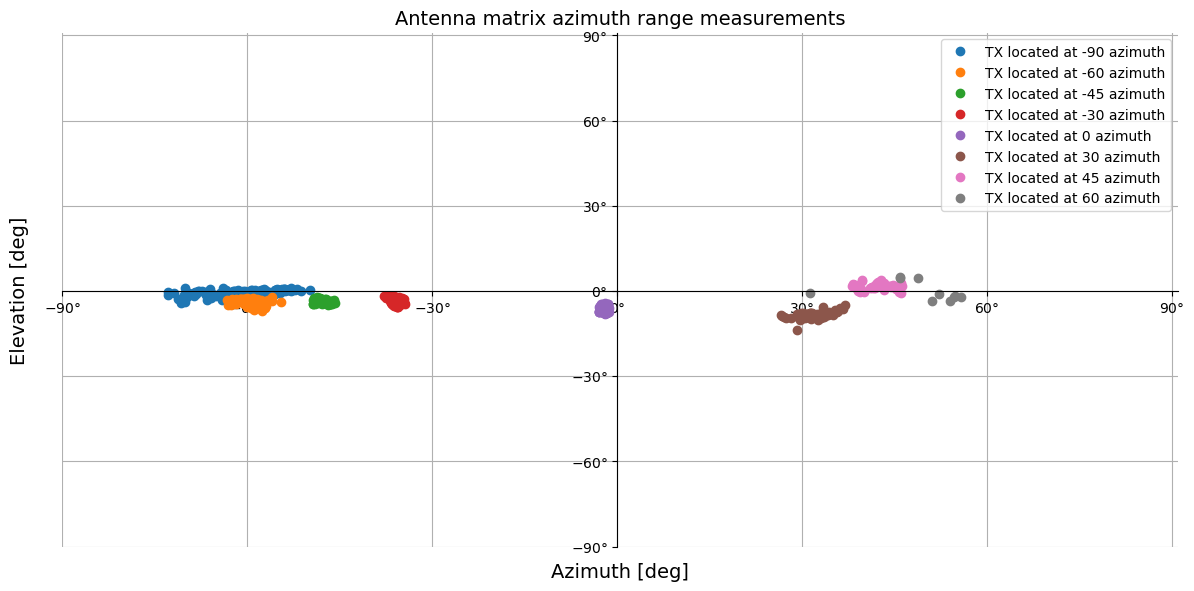

In [64]:
# Plots of received data in 1M and 2M PHY: Phase and Phase difference (COMPLEX PATTERN)

import math
import cmath
import json
from mpl_toolkits.axisartist.axislines import AxesZero
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

###################################################################
### Constants

vel_air = 299702547 # m/s
d = 0.05

###################################################################
### Methods

def to_plus_minus_pi(angle):
    while angle >= 180:
        angle -= 2 * 180
    while angle < -180:
        angle += 2 * 180
    return angle

def calc_mean(values):
    return sum(values)/len(values)

def calc_angle(deg_value, inverted, results, freq):
    wave_len = vel_air/freq
    output = 0
    try:
        result = math.acos((np.deg2rad(deg_value)*wave_len)/(2*math.pi*d))
    except ValueError:
        pass
    else:
        if inverted:
            output = abs(to_plus_minus_pi(np.rad2deg(result)+180))
        else:
            output = abs(to_plus_minus_pi(np.rad2deg(result)))
        results.append(output)

def channel_2_freq(channel):
    freq = 2450 #MHz
    if(channel <= 10):
        freq = 2404 + channel*2
    elif(channel < 37):
        freq = 2428 + (channel-11)*2
    elif(channel == 37):
        freq = 2402
    elif(channel == 38):
        freq = 2426
    else:
        freq = 2480
    return freq*1000000

###################################################################

max = ["log_2022.10.31_15.42.39.json", "log_2022.10.31_15.44.27.json", 
        "log_2022.10.31_15.46.15.json", "log_2022.10.31_15.48.07.json", 
        "log_2022.10.31_15.50.06.json", "log_2022.10.31_15.52.18.json", 
        "log_2022.10.31_15.54.14.json", "log_2022.10.31_15.57.26.json"]

mid = ["log_2022.10.31_15.40.15.json", "log_2022.10.31_15.37.15.json", 
        "log_2022.10.31_15.35.32.json", "log_2022.10.31_15.33.48.json", 
        "log_2022.10.31_15.32.02.json", "log_2022.10.31_15.29.53.json", 
        "log_2022.10.31_15.28.10.json", "log_2022.10.31_15.26.08.json"]

min = ["log_2022.10.31_15.00.48.json", "log_2022.10.31_15.03.12.json", 
        "log_2022.10.31_15.05.16.json", "log_2022.10.31_15.07.55.json", 
        "log_2022.10.31_15.09.56.json", "log_2022.10.31_15.12.23.json", 
        "log_2022.10.31_15.14.25.json", "log_2022.10.31_15.16.16.json"]

combined_azim = []
combined_elev = []

for log in min:

    data = []
    with open(f"../logs/outdoor/2022.10.31/{log}") as f:
        log = json.load(f)
        record_data = {
            "Header": log["Header"],
            "Records": [elem for elem in log["Records"] if len(elem["IQ"]) > 80]
        }
        data.append(record_data)

    results_azimuth = []
    results_elevation = []

    # Iterate through each connection event 
    for n in range(len(data[0]["Records"])-1):
        IQ = []
        channel = data[0]["Records"][n]["Channel"]

        # Iterate through each IQ sample to normalize it 
        for elem in data[0]["Records"][n]["IQ"]:
            I = elem[0]/128 if elem[0] < 0 else elem[0]/127
            Q = elem[1]/128 if elem[1] < 0 else elem[1]/127
            IQ.append(complex(I,Q))

        refPeriodDiff = []
        sampPeriodDiff = []
        refMeanDiff = 0

        # Iterate through each sample (82) in one connection event 
        for i in range(len(IQ)-1):
            # Phase calculation from IQ samples
            phaseCurrent = np.rad2deg(np.arctan2(IQ[i].imag, IQ[i].real))
            phaseNext = np.rad2deg(np.arctan2(IQ[i + 1].imag, IQ[i + 1].real))

            if (i < 7):
                refPeriodDiff.append(abs(to_plus_minus_pi(phaseNext - phaseCurrent)))
            elif (i == 7):
                refMeanDiff = calc_mean(refPeriodDiff)
            else:
                # 2*refMeanDiff as a in ref period sample is taken twice as fast as in sampling period, 
                # so it needs to be doubled
                sampPeriodDiff.append(to_plus_minus_pi((phaseNext - phaseCurrent) - 2*refMeanDiff))

        azimuth = []
        elevation = []
        inverted = False
        horizontal = True

        # Calculate direction angles
        for i in range(len(sampPeriodDiff)-1):
            # Skip corner differences samples
            if ((i + 1) % 4 == 0):
                if(not horizontal): 
                    # Change to inverted after 2 sections of non inverted data due to opposite scanning direction
                    inverted = not inverted
                # Change orientation after each section 
                horizontal = not horizontal
            else:
                if (horizontal):
                    calc_angle(sampPeriodDiff[i], inverted, azimuth, channel_2_freq(channel))
                else:
                    calc_angle(sampPeriodDiff[i], inverted, elevation, channel_2_freq(channel))

        results_azimuth.append(calc_mean(azimuth)-90)
        results_elevation.append(calc_mean(elevation)-90)

    combined_azim.append(results_azimuth)
    combined_elev.append(results_elevation)

fig = plt.figure(figsize=(12, 6), dpi=100)
ax = fig.add_subplot()
ax.grid(True)
ax.set_xlim(-90,91)
ax.set_ylim(-90,91)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)  
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.xaxis.set_label_coords(0, -0.03)
ax.yaxis.set_label_coords(-0.03, 0)
ax.set_ylabel('Elevation [deg]', fontsize='14')
ax.set_xlabel('Azimuth [deg]', fontsize='14')
ticks = np.arange(-90,91,30)
ax.xaxis.set_ticks(ticks, [f"${i}\degree$" for i in ticks])
ax.yaxis.set_ticks(ticks, [f"${i}\degree$" for i in ticks])
ax.set_title("Antenna matrix azimuth range measurements", fontsize='14')
plot_ticks = [-90, -60, -45, -30, 0, 30, 45, 60]

for i in range(0, len(max)):
    plt.plot(combined_azim[i], combined_elev[i], 'o', label=f'TX located at {plot_ticks[i]} azimuth')
plt.legend(loc='best')
plt.tight_layout()
plt.show()